In [5]:
# biblioteke

import cv2
import numpy as np
import itertools
import matplotlib.pyplot as plt
import os

In [ ]:
# ARUCO
IMAGE_PATHS = []
for file in os.listdir('test_data'):
    if file.endswith('.jpg'):
        image_path = os.path.join('test_data', file)
        IMAGE_PATHS.append(image_path)

OUTPUT_IMAGE_PATH = 'test_data_aruco'
ARUCO_DICTIONARY = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
ARUCO_ID = 23
MARKER_SIZE_IN_PIXELS = 150
MARGIN_FROM_CORNER_IN_PIXELS = 25

ARUCO_DICTIONARY = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
ARUCO_ID = 23
IMAGE_SIZE_PIXELS = 80

FILENAME = "Aruco_Marker_ID_23.png"

marker_image = np.zeros((IMAGE_SIZE_PIXELS, IMAGE_SIZE_PIXELS), dtype=np.uint8)

marker_image = cv2.aruco.generateImageMarker(
    ARUCO_DICTIONARY,
    ARUCO_ID,
    IMAGE_SIZE_PIXELS,
    marker_image,
    1 # borderBits
)

cv2.imwrite(FILENAME, marker_image)

print(f"Marker je uspešno sačuvan kao '{FILENAME}'")

Marker je uspešno sačuvan kao 'Aruco_Marker_ID_23.png'


In [7]:

def add_aruco_to_image(input_path, output_path):
    """
    Učitava sliku, generiše Aruco marker i postavlja ga u donji levi ugao.
    """
    background_image = cv2.imread(input_path)
    if background_image is None:
        print(f"Greška: Nije moguće učitati sliku sa putanje: {input_path}")
        return

    print(f"Originalna slika učitana (Dimenzije: {background_image.shape[1]}x{background_image.shape[0]})")

    print(f"Generišem Aruco marker sa ID: {ARUCO_ID} i veličinom: {MARKER_SIZE_IN_PIXELS}x{MARKER_SIZE_IN_PIXELS} px...")
    marker_image = np.zeros((MARKER_SIZE_IN_PIXELS, MARKER_SIZE_IN_PIXELS), dtype=np.uint8)
    marker_image = cv2.aruco.generateImageMarker(
        ARUCO_DICTIONARY,
        ARUCO_ID,
        MARKER_SIZE_IN_PIXELS,
        marker_image,
        1
    )
    bgr_marker_image = cv2.cvtColor(marker_image, cv2.COLOR_GRAY2BGR)
    img_height, img_width, _ = background_image.shape

    y_start = img_height - MARGIN_FROM_CORNER_IN_PIXELS - MARKER_SIZE_IN_PIXELS
    y_end = img_height - MARGIN_FROM_CORNER_IN_PIXELS

    x_start = MARGIN_FROM_CORNER_IN_PIXELS
    x_end = MARGIN_FROM_CORNER_IN_PIXELS + MARKER_SIZE_IN_PIXELS

    if y_start < 0 or x_end > img_width:
        print("Greška: Veličina markera ili margine je prevelika za datu sliku.")
        return

    background_image[y_start:y_end, x_start:x_end] = bgr_marker_image

    cv2.imwrite(output_path, background_image)
    print(f"Nova slika je uspešno sačuvana na: {output_path}")

OUTPUT_IMAGE_PATH = 'test_data_aruco'
for idx, INPUT_IMAGE_PATH in enumerate(IMAGE_PATHS):
    OUTPUT_IMAGE_PATH = os.path.join(OUTPUT_IMAGE_PATH, f"image_with_aruco_{idx+1}.jpg")
    add_aruco_to_image(INPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH)
    OUTPUT_IMAGE_PATH = 'test_data_aruco'

Originalna slika učitana (Dimenzije: 3000x4000)
Generišem Aruco marker sa ID: 23 i veličinom: 150x150 px...
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_1.jpg
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_1.jpg
Originalna slika učitana (Dimenzije: 3000x4000)
Generišem Aruco marker sa ID: 23 i veličinom: 150x150 px...
Originalna slika učitana (Dimenzije: 3000x4000)
Generišem Aruco marker sa ID: 23 i veličinom: 150x150 px...
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_2.jpg
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_2.jpg
Originalna slika učitana (Dimenzije: 3000x4000)
Generišem Aruco marker sa ID: 23 i veličinom: 150x150 px...
Originalna slika učitana (Dimenzije: 3000x4000)
Generišem Aruco marker sa ID: 23 i veličinom: 150x150 px...
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_3.jpg
Nova slika je uspešno sačuvana na: test_data_aruco\image_with_aruco_3.jpg
Originalna slika

In [8]:
# Kalibracija koordinantnog sistema

def get_pixel_to_mm_ratio(image, marker_id, real_marker_size_mm):
    """
    Ponalazi Aruco marker na slici i izračunava odnos piksela i milimetara.
    Ova funkcija pretpostavlja da je kamera direktno iznad
    i vraća prosečnu širinu markera u pikselima po milimetru.

    Args:
        image: Ulazna slika.
        marker_id: ID Aruco markera koji se traži.
        real_marker_size_mm: Stvarna veličina stranice markera u mm.

    Returns:
        Odnos piksela po milimetru ili None ako marker nije pronađen.
    """
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected = detector.detectMarkers(image)

    if ids is not None:
        for i, current_id in enumerate(ids):
            if current_id == marker_id:
                marker_corners = corners[i][0]

                width_px = np.linalg.norm(marker_corners[0] - marker_corners[1])
                height_px = np.linalg.norm(marker_corners[1] - marker_corners[2])

                avg_size_px = (width_px + height_px) / 2.0

                pixel_per_mm = avg_size_px / real_marker_size_mm
                print(f"Marker pronađen. Odnos: {pixel_per_mm:.2f} piksela/mm")
                return pixel_per_mm

    print("Aruco marker nije pronađen na slici.")
    return None

In [ ]:
def create_precise_mask(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_wood = np.array([8, 80, 50])
    upper_wood = np.array([30, 255, 255])

    color_mask = cv2.inRange(hsv_image, lower_wood, upper_wood)
    kernel_open = np.ones((9, 9), np.uint8)
    mask_no_noise = cv2.morphologyEx(color_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)

    contours, _ = cv2.findContours(mask_no_noise, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(mask_no_noise)

    min_area_threshold = 500
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area_threshold:
            cv2.drawContours(final_mask, [cnt], -1, 255, thickness=cv2.FILLED)

    return final_mask


IMAGE_DIR = "test_data_aruco"
RESULTS_DIR = "results_masks_final"

IMAGE_PATHS = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.png'))]

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

for image_path in IMAGE_PATHS:
    print(f"--- Obradjujem sliku: {os.path.basename(image_path)} ---")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Greška: Slika '{image_path}' nije pronađena."); continue

    precise_mask = create_precise_mask(image)


    output_filename = f"mask_{os.path.basename(image_path)}"
    output_path = os.path.join(RESULTS_DIR, output_filename)
    cv2.imwrite(output_path, precise_mask)
    print(f"Precizna maska sačuvana u: {output_path}")

print("\nObrada završena.")

--- Obradjujem sliku: image_with_aruco_1.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_1.jpg
--- Obradjujem sliku: image_with_aruco_2.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_1.jpg
--- Obradjujem sliku: image_with_aruco_2.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_2.jpg
--- Obradjujem sliku: image_with_aruco_3.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_2.jpg
--- Obradjujem sliku: image_with_aruco_3.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_3.jpg
--- Obradjujem sliku: image_with_aruco_4.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_3.jpg
--- Obradjujem sliku: image_with_aruco_4.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_4.jpg
--- Obradjujem sliku: image_with_aruco_5.jpg ---
Precizna maska sačuvana u: results_masks_final\mask_image_with_aruco_4.jpg
--- Obra

In [ ]:

def separate_connected_objects(mask, original_image_bgr):

    kernel_erode = np.ones((19, 19), np.uint8)
    eroded_for_seeds = cv2.erode(mask, kernel_erode, iterations=2)

    num_labels, markers = cv2.connectedComponents(eroded_for_seeds)
    if num_labels < 3:
        print("Upozorenje: Razdvajanje nije uspelo, objekat se tretira kao jedan.")
        _, markers = cv2.connectedComponents(mask)
        return markers

    print(f"Pronađeno {num_labels - 1} semena, pokušavam razdvajanje...")
    markers = markers + 1
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.watershed(mask_bgr, markers)

    return markers


def segment_objects(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_wood = np.array([10, 100, 120])
    upper_wood = np.array([25, 255, 255])
    mask = cv2.inRange(hsv_image, lower_wood, upper_wood)
    kernel_close = np.ones((21, 21), np.uint8)
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
    contours, _ = cv2.findContours(closed_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros(closed_mask.shape, dtype=np.uint8)
    min_area_threshold = 1000
    for cnt in contours:
        if cv2.contourArea(cnt) > min_area_threshold:
            cv2.drawContours(final_mask, [cnt], -1, (255), thickness=cv2.FILLED)

    separated_markers = separate_connected_objects(final_mask, image)

    return separated_markers


def analyze_and_get_object_data(markers_image, original_image, px_per_mm):

    object_data_list = []
    expected_area_mm2 = 610 * 105
    expected_area_px2 = expected_area_mm2 * (px_per_mm ** 2)

    labels = np.unique(markers_image)
    for label in labels:
        if label <= 1:
            continue

        mask = np.zeros(markers_image.shape, dtype="uint8")
        mask[markers_image == label] = 255

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            continue

        c = max(contours, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        if area_px < 100:
            continue

        if area_px > 1.5 * expected_area_px2:
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 150))
            split_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            sub_contours, _ = cv2.findContours(split_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for sc in sub_contours:
                sub_area_px = cv2.contourArea(sc)
                if sub_area_px < 100:
                    continue

                rect = cv2.minAreaRect(sc)
                (x_rect, y_rect), (width_px, height_px), angle = rect

                M = cv2.moments(sc)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                else:
                    cX, cY = int(x_rect), int(y_rect)

                width_mm = width_px / px_per_mm
                height_mm = height_px / px_per_mm
                duzina_mm = max(width_mm, height_mm)
                sirina_mm = min(width_mm, height_mm)
                if width_px < height_px:
                    angle += 90

                object_data_list.append({
                    "center_px": (cX, cY),
                    "center_mm": (round(cX / px_per_mm, 2), round(cY / px_per_mm, 2)),
                    "duzina_mm": round(duzina_mm, 2),
                    "sirina_mm": round(sirina_mm, 2),
                    "ugao": round(angle, 2)
                })

                box = cv2.boxPoints(rect)
                box = np.intp(box)
                cv2.drawContours(original_image, [box], 0, (0, 255, 255), 2)
                cv2.circle(original_image, (cX, cY), 4, (0, 255, 255), -1)

            continue

        rect = cv2.minAreaRect(c)
        (x_rect, y_rect), (width_px, height_px), angle = rect

        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = int(x_rect), int(y_rect)

        width_mm = width_px / px_per_mm
        height_mm = height_px / px_per_mm
        duzina_mm = max(width_mm, height_mm)
        sirina_mm = min(width_mm, height_mm)
        if width_px < height_px:
            angle += 90

        object_data_list.append({
            "center_px": (cX, cY),
            "center_mm": (round(cX / px_per_mm, 2), round(cY / px_per_mm, 2)),
            "duzina_mm": round(duzina_mm, 2),
            "sirina_mm": round(sirina_mm, 2),
            "ugao": round(angle, 2)
        })

        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(original_image, [box], 0, (0, 255, 0), 2)
        cv2.circle(original_image, (cX, cY), 5, (255, 0, 0), -1)
        cv2.putText(original_image, f"ID: {label-1}", (cX, cY - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    return object_data_list, original_image


def send_data_to_robot(serial_port, object_data):
    """
    Formira string sa podacima i šalje ga preko serijskog porta.

    Args:
        serial_port: Inicijalizovan serijski port (objekat).
        object_data: Rečnik sa podacima o jednom objektu.
    """
    # Formatiranje poruke: X,Y,Duzina,Sirina,Ugao\n
    msg = (f"{object_data['center_mm'][0]},{object_data['center_mm'][1]},"
           f"{object_data['duzina_mm']},{object_data['sirina_mm']},"
           f"{object_data['ugao']}\n")

    try:
        print(f"Slanje poruke: {msg.strip()}")
        # serial_port.write(msg.encode('utf-8'))
    except Exception as e:
        print(f"Greška pri slanju podataka: {e}")


if __name__ == "__main__":
    IMAGE_DIR = "test_data_aruco"
    IMAGE_PATHS = []
    for file in os.listdir(IMAGE_DIR):
        if file.endswith('.jpg'):
            IMAGE_PATH = os.path.join(IMAGE_DIR, file)
            IMAGE_PATHS.append(IMAGE_PATH)

    ARUCO_ID_TO_FIND = 23
    ARUCO_REAL_SIZE_MM = 50

    SERIAL_PORT_NAME = 'COM3'
    BAUD_RATE = 9600

    for i, IMAGE_PATH in enumerate(IMAGE_PATHS):
        image = cv2.imread(IMAGE_PATH)
        if image is None:
            print(f"Greška: Slika na putanji '{IMAGE_PATH}' nije pronađena.")
            exit()

        px_per_mm_ratio = get_pixel_to_mm_ratio(image, ARUCO_ID_TO_FIND, ARUCO_REAL_SIZE_MM)

        image_for_segmentation = image.copy()
        segmented_markers = segment_objects(image_for_segmentation)

        output_image = image.copy()
        detected_objects, output_image_with_data = analyze_and_get_object_data(
            segmented_markers, output_image, px_per_mm_ratio
        )

        print("\n--- DETEKTOVANI OBJEKTI ---")
        if not detected_objects:
            print("Nijedan objekat nije detektovan.")
        else:
            # Inicijalizacija serijskog porta
            # ser = None
            # try:
            #     ser = serial.Serial(SERIAL_PORT_NAME, BAUD_RATE, timeout=1)
            #     print(f"Serijski port {SERIAL_PORT_NAME} otvoren.")
            #     time.sleep(2) # Sačekati da se veza uspostavi
            # except serial.SerialException as e:
            #     print(f"Greška: Nije moguće otvoriti serijski port {SERIAL_PORT_NAME}. Radim u test modu.")
            #     print(e)

            # Slanje podataka za svaki detektovani objekat
            for i, obj in enumerate(detected_objects):
                print(f"\nObjekat #{i+1}:")
                print(f"  Centar (X, Y): {obj['center_mm']} mm")
                print(f"  Dužina: {obj['duzina_mm']} mm")
                print(f"  Širina: {obj['sirina_mm']} mm")
                print(f"  Ugao: {obj['ugao']} stepeni")

                # if ser and ser.is_open:
                #    send_data_to_robot(ser, obj)
                # else:
                #    # Ako port nije otvoren, samo ispisujemo poruku koja bi bila poslata
                send_data_to_robot(None, obj)

            # Zatvaranje serijskog porta
            # if ser and ser.is_open:
            #     ser.close()
            #     print("\nSerijski port zatvoren.")

        cv2.imwrite(f'results/output_{i}.jpg', output_image_with_data)

Marker pronađen. Odnos: 2.98 piksela/mm
Pronađeno 3 semena, pokušavam razdvajanje...
Pronađeno 3 semena, pokušavam razdvajanje...

--- DETEKTOVANI OBJEKTI ---

Objekat #1:
  Centar (X, Y): (np.float32(411.41), np.float32(362.75)) mm
  Dužina: 622.72998046875 mm
  Širina: 109.98999786376953 mm
  Ugao: 130.44 stepeni
Slanje poruke: 411.4100036621094,362.75,622.72998046875,109.98999786376953,130.44

Objekat #2:
  Centar (X, Y): (np.float32(364.43), np.float32(714.77)) mm
  Dužina: 605.0999755859375 mm
  Širina: 98.20999908447266 mm
  Ugao: 143.05 stepeni
Slanje poruke: 364.42999267578125,714.77001953125,605.0999755859375,98.20999908447266,143.05

Objekat #3:
  Centar (X, Y): (np.float32(628.52), np.float32(974.5)) mm
  Dužina: 625.2100219726562 mm
  Širina: 105.80000305175781 mm
  Ugao: 15.0 stepeni
Slanje poruke: 628.52001953125,974.5,625.2100219726562,105.80000305175781,15.0

--- DETEKTOVANI OBJEKTI ---

Objekat #1:
  Centar (X, Y): (np.float32(411.41), np.float32(362.75)) mm
  Dužina: 

In [10]:
# funckije

def get_corners_from_mask(mask, epsilon_factor=0.02):
    if mask.dtype != np.uint8: mask = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None, None
    main_contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(main_contour, True)
    approx_corners = cv2.approxPolyDP(main_contour, perimeter * epsilon_factor, True)
    return approx_corners, main_contour

def is_rectangle(points, tolerance=0.05):
    distances = sorted([np.linalg.norm(p1 - p2) for p1, p2 in itertools.combinations(points, 2)])
    diagonal1, diagonal2 = distances[-1], distances[-2]
    if abs(diagonal1 - diagonal2) > (diagonal1 * tolerance): return False
    side1_sq, side2_sq, side3_sq, side4_sq = [d**2 for d in distances[:4]]
    if abs((side1_sq + side4_sq) - diagonal1**2) > (diagonal1**2 * tolerance) and \
       abs((side2_sq + side3_sq) - diagonal1**2) > (diagonal1**2 * tolerance):
         return False
    return True

def is_filled(rect_points, original_mask, threshold=0.9):
    mask_rect = np.zeros_like(original_mask)
    cv2.fillPoly(mask_rect, [np.int32(rect_points)], 255)
    area_rect = np.count_nonzero(mask_rect)
    if area_rect == 0: return False
    intersection = cv2.bitwise_and(original_mask, mask_rect)
    area_intersection = np.count_nonzero(intersection)
    fill_ratio = area_intersection / area_rect
    return fill_ratio > threshold

def are_angles_parallel(angle1, angle2, tolerance=5.0):
    diff = abs(angle1 - angle2)
    return diff < tolerance or abs(diff - 90.0) < tolerance

def check_dimensions_and_modularity(points, target_width, width_tolerance=0.1, min_ratio=4.8):
    distances = sorted([np.linalg.norm(p1 - p2) for p1, p2 in itertools.combinations(points, 2)])
    side_a = distances[0]
    side_b = distances[2]

    ratio_a = side_a / target_width
    ratio_b = side_b / target_width

    is_modular_a = abs(ratio_a - round(ratio_a)) < width_tolerance
    is_modular_b = abs(ratio_b - round(ratio_b)) < width_tolerance

    if not (is_modular_a or is_modular_b):
        return False

    if (round(ratio_a) == 1 and is_modular_a) or (round(ratio_b) == 1 and is_modular_b):
        side_short = min(side_a, side_b)
        side_long = max(side_a, side_b)
        if (side_long / side_short) < min_ratio:
            return False

    return True

def remove_overlaps(rectangles, iou_threshold=0.3):
    if not rectangles:
        return []

    rectangles.sort(key=lambda r: cv2.contourArea(r))

    final_rects = []
    for rect in rectangles:
        has_large_overlap = False
        for final_rect in final_rects:
            if calculate_iou(rect, final_rect) > iou_threshold:
                has_large_overlap = True
                break

        if not has_large_overlap:
            final_rects.append(rect)

    return final_rects

def calculate_iou(rect1_pts, rect2_pts):
    mask1 = np.zeros(sample_mask.shape, dtype=np.uint8)
    cv2.fillPoly(mask1, [np.int32(rect1_pts)], 255)

    mask2 = np.zeros(sample_mask.shape, dtype=np.uint8)
    cv2.fillPoly(mask2, [np.int32(rect2_pts)], 255)

    intersection = np.count_nonzero(cv2.bitwise_and(mask1, mask2))
    union = np.count_nonzero(cv2.bitwise_or(mask1, mask2))

    return intersection / union if union > 0 else 0

def visualize_decomposition(mask, valid_rectangles, main_corners):
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap='gray')
    colors = ['lime', 'cyan', 'yellow', 'magenta']
    for i, rect_points in enumerate(valid_rectangles):
        plt.fill(rect_points[:, 0], rect_points[:, 1], color=colors[i % len(colors)], alpha=0.7, label=f'Deo {i+1}')
    plt.title(f"Finalna dekompozicija na {len(valid_rectangles)} oblika")

    for main_corner in main_corners:
        plt.plot(main_corner[:,0], main_corner[:,1], 'ro', markersize=12)

    plt.legend()
    plt.gca().invert_yaxis()
    plt.show()

def split_rectangle(rect_points, n_splits):
    if n_splits <= 1:
        return [rect_points]

    center, (w, h), angle = cv2.minAreaRect(rect_points)

    if w < h:
        split_dim_size = w
        fixed_dim_size = h
        split_axis_is_width = True
    else:
        split_dim_size = h
        fixed_dim_size = w
        split_axis_is_width = False

    new_split_dim_size = split_dim_size / n_splits

    angle_rad = np.deg2rad(angle)
    vec_w = np.array([np.cos(angle_rad), np.sin(angle_rad)])
    vec_h = np.array([-np.sin(angle_rad), np.cos(angle_rad)])

    split_axis_vector = vec_w if split_axis_is_width else vec_h

    sub_rects = []
    start_offset = -split_dim_size / 2 + new_split_dim_size / 2

    for i in range(n_splits):
        current_offset = start_offset + i * new_split_dim_size
        new_center = np.array(center) + current_offset * split_axis_vector

        if split_axis_is_width:
            new_size = (new_split_dim_size, fixed_dim_size)
        else:
            new_size = (fixed_dim_size, new_split_dim_size)

        new_rotated_rect = (tuple(new_center), new_size, angle)
        sub_rects.append(np.intp(cv2.boxPoints(new_rotated_rect)))

    return sub_rects

Glavni ugao cele figure: 53.52 stepeni.
Testiranje 495 mogućih pravougaonika...

Pronađeno 4 kandidata koji zadovoljavaju sve kriterijume.

Pronađeno 4 kandidata koji zadovoljavaju sve kriterijume.
Pronađeno 3 nepreklapajućih oblika.

--- REZULTAT ---
Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: 3
Pronađeno 3 nepreklapajućih oblika.

--- REZULTAT ---
Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: 3


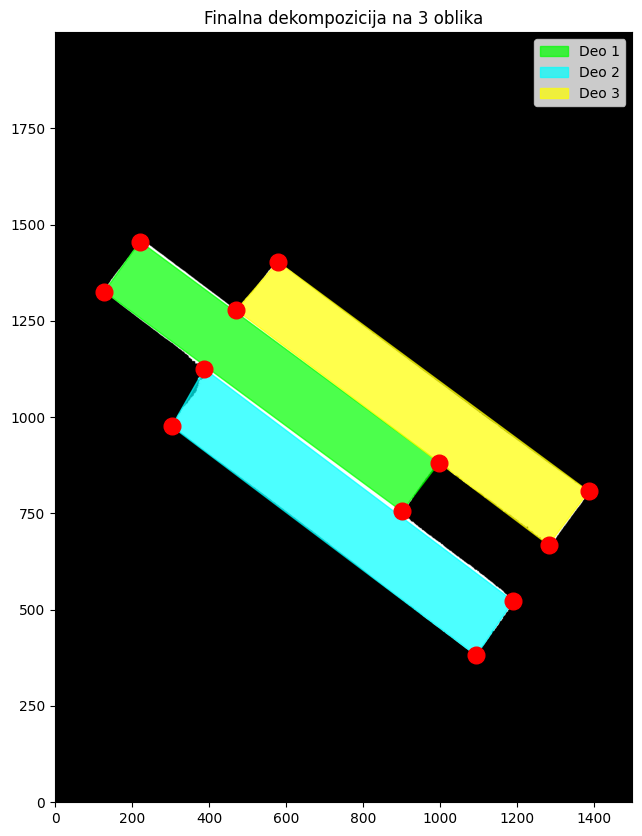

Glavni ugao cele figure: 59.50 stepeni.
Testiranje 70 mogućih pravougaonika...

Pronađeno 2 kandidata koji zadovoljavaju sve kriterijume.
Pronađeno 2 nepreklapajućih oblika.
Detektovan složen oblik (širina ~2x). Delim ga...

--- REZULTAT ---
Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: 3


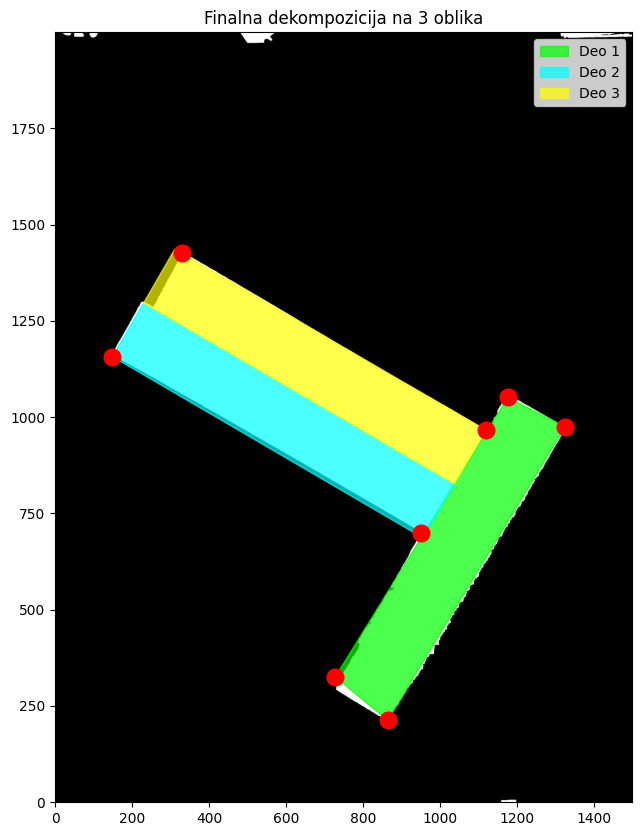

Glavni ugao cele figure: 86.92 stepeni.
Testiranje 715 mogućih pravougaonika...

Pronađeno 8 kandidata koji zadovoljavaju sve kriterijume.
Pronađeno 3 nepreklapajućih oblika.

--- REZULTAT ---
Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: 3

Pronađeno 8 kandidata koji zadovoljavaju sve kriterijume.
Pronađeno 3 nepreklapajućih oblika.

--- REZULTAT ---
Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: 3


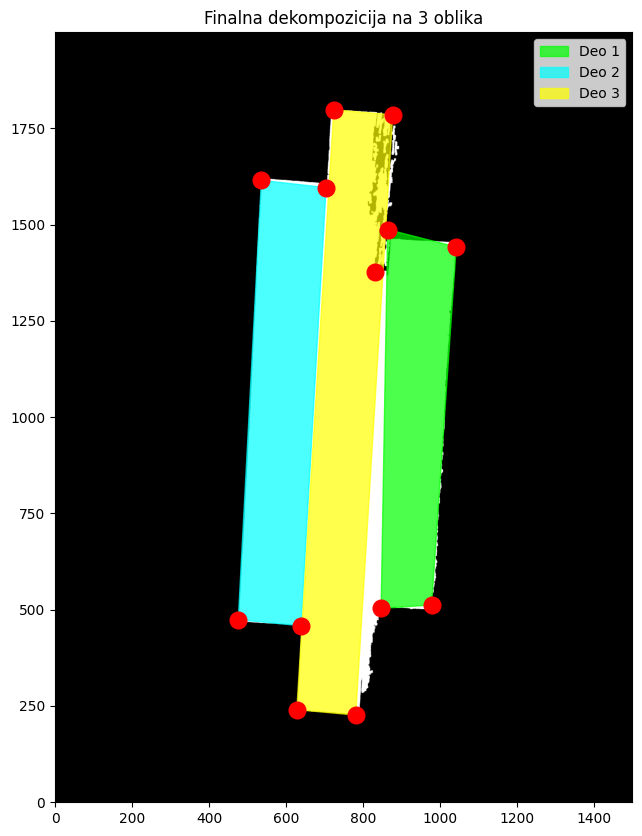

In [ ]:

IMAGE_DIR = "results_masks_final"
IMAGE_PATHS = []
for file in os.listdir(IMAGE_DIR):
    if file.endswith('.jpg'):
        IMAGE_PATH = os.path.join(IMAGE_DIR, file)
        IMAGE_PATHS.append(IMAGE_PATH)

TARGET_WIDTH = 190
WIDTH_TOLERANCE = 0.2
MINIMUM_LENGTH_RATIO = 5.0
IOU_THRESHOLD = 0.3

for FILE_PATH in IMAGE_PATHS:
    sample_mask = cv2.imread(FILE_PATH, cv2.COLOR_BAYER_BGGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    sample_mask = cv2.morphologyEx(sample_mask, cv2.MORPH_CLOSE, kernel)

    main_corners, main_contour = get_corners_from_mask(sample_mask, epsilon_factor=0.01)

    if main_corners is not None:
        all_corners = main_corners.reshape(-1, 2)
        _, _, main_angle = cv2.minAreaRect(main_contour)
        print(f"Glavni ugao cele figure: {main_angle:.2f} stepeni.")

        candidate_rects = []

        num_combinations = len(list(itertools.combinations(all_corners, 4)))
        print(f"Testiranje {num_combinations} mogućih pravougaonika...")

        for points_combination in itertools.combinations(all_corners, 4):

            quad_points = np.array(points_combination)

            if not is_rectangle(quad_points): continue
            if not is_filled(quad_points, sample_mask): continue
            _, _, candidate_angle = cv2.minAreaRect(quad_points)
            if not are_angles_parallel(main_angle, candidate_angle): continue
            if not check_dimensions_and_modularity(quad_points, TARGET_WIDTH, WIDTH_TOLERANCE, MINIMUM_LENGTH_RATIO): continue

            candidate_rects.append(quad_points)

        print(f"\nPronađeno {len(candidate_rects)} kandidata koji zadovoljavaju sve kriterijume.")

        final_rectangles = remove_overlaps(candidate_rects, IOU_THRESHOLD)

        initial_shapes = final_rectangles
        print(f"Pronađeno {len(initial_shapes)} nepreklapajućih oblika.")

        final_decomposed_shapes = []
        for shape in initial_shapes:
            distances = sorted([np.linalg.norm(p1 - p2) for p1, p2 in itertools.combinations(shape, 2)])
            short_side = distances[0]

            width_multiple = round(short_side / TARGET_WIDTH)

            if width_multiple > 1:
                print(f"Detektovan složen oblik (širina ~{width_multiple}x). Delim ga...")
                split_shapes = split_rectangle(shape, int(width_multiple))
                final_decomposed_shapes.extend(split_shapes)
            else:
                final_decomposed_shapes.append(shape)

        print("\n--- REZULTAT ---")
        print(f"Nakon finalne dekompozicije, ukupan broj osnovnih oblika je: {len(final_decomposed_shapes)}")

        final_rectangles = final_decomposed_shapes
        if final_rectangles:
            visualize_decomposition(sample_mask, final_rectangles, main_corners)
        else:
            print("Nije pronađen nijedan pravougaonik koji zadovoljava sve kriterijume.")